## Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import mediapipe as mp

In [ ]:
import cv2

def do_salience(image, model, label, prefix):
  '''
  Generates the saliency map of a given image.

  Args:
    image (file) -- picture that the model will classify
    model (keras Model) -- your cats and dogs classifier
    label (int) -- ground truth label of the image
    prefix (string) -- prefix to add to the filename of the saliency map
  '''

  # Read the image and convert channel order from BGR to RGB
  # if the image is not path but image tensor type
  if isinstance(image, str):
    img = cv2.imread(image)
  else:
    img = image if isinstance(image, np.ndarray) else image.numpy()
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Resize the image to 128x128 and normalize pixel values to the range [0, 1]
  img = cv2.resize(img, (128,128)) / 255.0

  # Add an additional dimension (for the batch), and save this in a new variable
  img = np.expand_dims(img, axis=0)
  img_var = tf.Variable(img)

  # Declare the number of classes
  num_classes = 29

  # Define the expected output array by one-hot encoding the label
  expected_output = tf.one_hot([label], num_classes)

  with tf.GradientTape() as tape:
    inputs = tf.cast(img_var, tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
    loss = tf.keras.losses.categorical_crossentropy(
        y_true=expected_output,
        y_pred=predictions,
    )

  # get the gradients of the loss with respect to the model's input image
  gradients = tape.gradient(loss, inputs)

  # generate the grayscale tensor
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  normalized_tensor = tf.cast(
      255
      * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
      / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
      tf.uint8
  )

  # Remove dimensions that are size 1
  normalized_tensor = tf.squeeze(normalized_tensor)

  # superimpose the saliency map with the original image, then display it.
  gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  img = img[0]
  super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)

  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(super_imposed)
  plt.show()

In [ ]:
def load_datasets(train_dir, val_dir=None, img_width=128, img_height=128, batch_size=256):
    """
    Load datasets from the specified directories.

    Args:
        train_dir (str): Path to the training data directory.
        val_dir (str): Path to the validation data directory.
        test_dir (str): Path to the testing data directory.
        img_width (int): Width of the images to be resized to.
        img_height (int): Height of the images to be resized to.
        batch_size (int): Batch size for loading the datasets.

    Returns:
        tuple: train_dataset, validation_dataset, test_dataset
    """
    image_size = (img_width, img_height)
    buffer_size = tf.data.AUTOTUNE

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size,
        interpolation="nearest",
        batch_size=batch_size,
        shuffle=True
    )

    # Load validation dataset
    if (val_dir):
      validation_dataset = tf.keras.utils.image_dataset_from_directory(
          val_dir,
          labels='inferred',
          label_mode='categorical',
          image_size=image_size,
          interpolation="nearest",
          batch_size=batch_size,
          shuffle=False
      )
      validation_dataset = validation_dataset.cache().prefetch(buffer_size=buffer_size)
    else:
      validation_dataset = None

    # Configure datasets for performance
    train_dataset = train_dataset.cache().prefetch(buffer_size=buffer_size)

    return train_dataset, validation_dataset

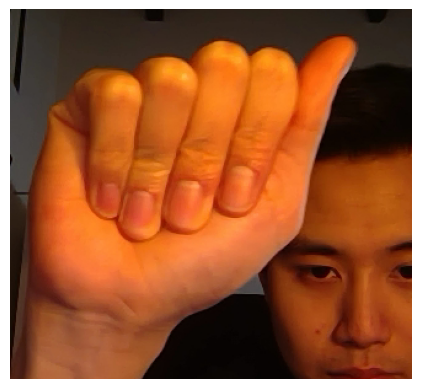

In [ ]:
# Preprocessing: Use a hand detection model (e.g., Mediapipe or YOLO) to preprocess images by cropping and focusing only on the hand region. This reduces background distractions.
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

def crop_hand(image_path):
    """Crop the hand region from an image using MediaPipe Hands.

    Args:
        image_path (str): Path to the image file.

    Returns:
        np.array: Cropped hand region.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

    # Process the image
    results = hands.process(image)

    # Get the hand landmarks
    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape

    # Get the bounding box
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0
    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    # Add padding
    padding = 60
    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    # Crop the hand region
    hand_image = image[y_min:y_max, x_min:x_max]

    plt.imshow(hand_image)
    plt.axis("off")
    plt.show()
    return hand_image
image = "C:\\Users\\user\\Downloads\\capstone\\ASL_Alphabet_Dataset\\asl_alphabet_train\\A\\122.jpg"
hand_image = crop_hand(image)

## Load Dataset

In [ ]:
train_asl_before, val_asl_before = load_datasets("../data/asl_alphabet_train", "C:\\Users\\user\\Downloads\\capstone\\val")
test_data, _ = load_datasets("C:\\Users\\user\\Downloads\\capstone\\test")
train_asl_dir = r'C:\Users\user\Downloads\capstone\ASL_Alphabet_Dataset\asl_alphabet_train'
train_asl, _ = load_datasets(train_asl_dir)

Found 87000 files belonging to 29 classes.
Found 8700 files belonging to 29 classes.
Found 579 files belonging to 29 classes.
Found 223074 files belonging to 29 classes.


In [ ]:
new_test, _ = load_datasets("C:\\Users\\user\\Downloads\\capstone\\new_test")

Found 870 files belonging to 29 classes.


In [ ]:
model = tf.keras.models.load_model('resnet50_newdata_2ep.keras')
model_v1 = tf.keras.models.load_model('sign_language_model_v1.keras')
base_model = tf.keras.models.load_model('sign_language_base_model.keras')

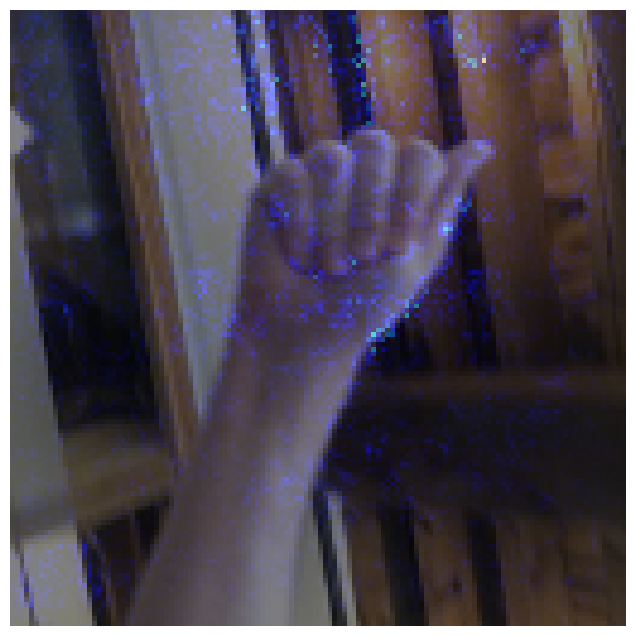

In [ ]:
# asd image_path='C:\\Users\\user\\Downloads\\capstone\\test\\A\\IMG_20241130_104251.jpg'
image_path='C:\\Users\\user\\Downloads\\capstone\\new_test\\A\\A0030_test.jpg'
do_salience(image_path, model, 0, 'A')
# hand_image = crop_hand(image_path)
# do_salience(hand_image, model, 0, 'A')

In [ ]:
model.evaluate(new_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9727 - loss: 0.1023


[0.10255350917577744, 0.9724137783050537]

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Initialize MediaPipe Hands once outside the loop for efficiency
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def crop_hand(image_path, padding=150):
    """Crop the hand region from an image using MediaPipe Hands."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image)
    if not results.multi_hand_landmarks:
        return image  # Return the original image if no hands are detected

    landmarks = results.multi_hand_landmarks[0].landmark
    image_height, image_width, _ = image.shape
    x_min, x_max, y_min, y_max = image_width, 0, image_height, 0

    for landmark in landmarks:
        x, y = landmark.x, landmark.y
        x_pixel, y_pixel = int(x * image_width), int(y * image_height)
        x_min, x_max = min(x_min, x_pixel), max(x_max, x_pixel)
        y_min, y_max = min(y_min, y_pixel), max(y_max, y_pixel)

    x_min = max(0, x_min - padding)
    x_max = min(image_width, x_max + padding)
    y_min = max(0, y_min - padding)
    y_max = min(image_height, y_max + padding)

    return image[y_min:y_max, x_min:x_max]

def preprocess_image(image_path, padding=150):
    """Preprocess image for model input."""
    hand_image = crop_hand(image_path, padding)
    resized_hand_image = cv2.resize(hand_image, (128, 128))
    resized_hand_image = np.expand_dims(resized_hand_image, axis=0)  # Add batch dimension
    return resized_hand_image

def load_data_from_folder(folder_path, padding=150):
    """Load images and labels from folder."""
    images = []
    labels = []

    for label_name in class_names:
        label_folder = os.path.join(folder_path, label_name)
        if not os.path.isdir(label_folder):
            continue  # Skip if folder for the label does not exist

        for image_name in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_name)
            if not os.path.isfile(image_path):
                continue

            # Preprocess the image and label
            images.append(preprocess_image(image_path, padding))
            labels.append(class_names.index(label_name))

    images = np.vstack(images)  # Stack all images into a single numpy array
    labels = np.array(labels)  # Convert labels to numpy array
    return images, labels

def evaluate_model_on_folder(folder_path, model, class_names, padding=150):
    """Evaluate the model on a folder of images."""
    images, true_labels = load_data_from_folder(folder_path, padding)

    # Batch the data for better performance
    batch_size = 32
    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)

    # Make predictions in batches
    predictions = model.predict(images_tensor, batch_size=batch_size)
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy, F1 score, and confusion matrix
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

In [ ]:
new_test_folder = 'C:\\Users\\user\\Downloads\\capstone\\new_test'
# link : https://www.kaggle.com/datasets/danrasband/asl-alphabet-test?select=W
evaluate_model_on_folder(new_test_folder, model, class_names, padding=150)

28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step
Accuracy: 0.9459770114942528
F1 Score: 0.9457684001079738
Confusion Matrix:
 [[30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 1 28  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0 28  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  2  0  0  0 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  3 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0 29  0  0  0  0  0  0  0 

In [ ]:
# Test data from manual collection
test_folder = 'C:\\Users\\user\\Downloads\\capstone\\test'

In [ ]:
evaluate_model_on_folder(test_folder, model, class_names) #100 padding

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 321ms/step
Accuracy: 0.3920552677029361
F1 Score: 0.35873624204936455
Confusion Matrix:
 [[13  0  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0  0  3  0  0  0  0  1
   0  0  0  0  0]
 [ 1 13  0  0  2  0  1  0  0  0  0  0  1  0  0  0  0  0  0  2  0  0  0  0
   0  0  0  0  0]
 [ 0  0 15  0  0  0  1  2  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  2  0  0  1  0  0  0  7  1  0  0  0  7
   0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0
   0  0  0  0  0]
 [ 0  4  0  0  3  4  0  0  0  0  0  0  1  0  0  0  0  0  2  4  0  0  0  2
   0  0  0  0  0]
 [ 1  0  0  0  0  0 11  0  0  0  0  0  3  0  0  0  0  0  5  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  1  0  0  0 15  3  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  3  0  0  0  0  0  0  3  0  0  0  0 11
   0  1  0  0  0]
 [ 0  0  0  0  0  0  1  0  1  8  0  0  0  0  1  0  0 

c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluate_model_on_folder(test_folder, model, class_names) #120 padding

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step
Accuracy: 0.40414507772020725
F1 Score: 0.3649899257983754
Confusion Matrix:
 [[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  1
   0  0  0  0  0]
 [ 2 12  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  0  0  0
   1  0  0  0  0]
 [ 0  0 16  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 1  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  7  2  1  0  0  6
   0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0
   0  0  0  0  0]
 [ 0  3  0  0  4  5  0  0  0  0  0  1  1  0  0  0  0  0  2  3  0  0  0  1
   0  0  0  0  0]
 [ 2  0  1  0  0  0  9  0  0  0  0  0  2  0  0  0  0  0  5  0  0  0  0  0
   0  0  1  0  0]
 [ 0  0  5  0  0  0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0 15
   0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  7  0  0  0  0  0  0  0 

c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluate_model_on_folder(test_folder, model, class_names, padding=155)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step
Accuracy: 0.4438687392055268
F1 Score: 0.4011970030391692
Confusion Matrix:
 [[15  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  3  1  0  0  0  0
   0  0  0  0  0]
 [ 2 13  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   1  0  0  0  0]
 [ 0  0 17  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  3  3  0  1  0  9
   0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0
   0  0  0  0  0]
 [ 0  4  0  0  6  6  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  3
   0  0  0  0  0]
 [ 2  1  1  0  0  0  9  0  0  0  0  0  1  0  0  0  0  0  5  0  0  0  0  0
   0  0  0  0  1]
 [ 0  0  6  0  0  0  9  4  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  2  0  0  3  0  0  0  0  0  0  1  0  0  0  0 11
   0  0  0  0  1]
 [ 0  0  0  0  2  0  2  0  2  4  0  0  0  0  0  0  0  

c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluate_model_on_folder(test_folder, model, class_names, padding=130)

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step
Accuracy: 0.4110535405872193
F1 Score: 0.36582015194998946
Confusion Matrix:
 [[17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0
   0  0  0  0  0]
 [ 2 13  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0
   1  0  0  0  0]
 [ 0  0 16  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  3  0  0  1  0  0  0  4  3  0  0  0  7
   0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0
   0  0  0  0  0]
 [ 0  3  0  0  3  4  0  0  0  0  0  1  2  0  0  0  0  0  2  4  0  0  0  1
   0  0  0  0  0]
 [ 2  1  1  0  0  0  9  0  0  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0
   0  0  2  0  0]
 [ 0  0  4  0  1  0 12  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0 15
   0  0  0  0  0]
 [ 0  0  0  0  2  0  1  0  0  7  0  0  0  0  0  0  0 

c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluate_model_on_folder(test_folder, model, class_names, padding=150)

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step
Accuracy: 0.44559585492227977
F1 Score: 0.3988467510724044
Confusion Matrix:
 [[18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0
   0  0  0  0  0]
 [ 2 13  0  0  3  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   1  0  0  0  0]
 [ 0  0 17  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 0  0  1  0  1  1  0  0  0  0  0  2  1  0  0  0  0  0  5  1  0  1  0  7
   0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0
   0  0  0  0  0]
 [ 0  2  0  0  5  6  0  0  0  0  0  1  0  0  0  0  0  0  0  3  0  0  0  3
   0  0  0  0  0]
 [ 1  1  1  0  0  0 10  0  0  0  0  0  1  0  0  0  0  0  5  0  0  0  0  0
   0  0  0  0  1]
 [ 0  0  6  0  0  0 10  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  1  0  1  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0 14
   0  0  0  0  0]
 [ 0  0  0  0  3  0  3  0  0  5  0  0  0  0  0  0  0 

c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\cudanerb\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
